# Accent classification with recurrent networks

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
#torch.multiprocessing.set_start_method("spawn")

In [2]:
# Restart from here
DEV = False
EPOCHS = 100

DEBUG = False
NUM_CONCAT = 20

In [3]:
# autoreloads
%reload_ext autoreload
%autoreload 1
%aimport parameters

# Allows to load modules from parent directory
from time import time
import inspect, sys, os, json
from os.path import dirname, abspath
sys.path.append(dirname(dirname(abspath(inspect.getfile(inspect.currentframe())))))

from pathlib import Path
from os import makedirs

from tqdm import tqdm_notebook as tqdm

import numpy as np
import pandas as pd

from data.data_loader import create_binarizer, get_accents_counts
from utils import count_parameters
from models.modules import BatchRNN

from tensorboardX import SummaryWriter

import math

from torch.utils.data import DataLoader, Dataset

In [4]:
param = parameters.get_parameters(dev=DEV, epochs=EPOCHS, us_en=True)

## Utilities

In [5]:
def val_cnts(list_):
    return pd.Series(list_).value_counts()

def extract_num (s):
    return ''.join([c if c.isdigit() else '' for c in s])

def ids_list(manifest):
    ids = []
    with open(manifest) as f:
        for l in f:
            s = l.split('/')
            ids.append(f'{s[3]}-{s[5].split(".")[0]}')
    return ids

def make_accent_dict(manifest_path):
    accent_dict = {}
    class_dict = {}
    with open(manifest_path) as f:
        for l in f:
            wav, txt, acc = l.split(',')
            num = extract_num(wav)
            accent = acc.strip()
            if accent not in class_dict:
                new_key = 0 if (len(class_dict) == 0) else max(class_dict.values()) + 1
                class_dict[accent] = new_key
            accent_dict[num] = class_dict[accent]
    return accent_dict, {v: k for k, v in class_dict.items()}

## Data Loading

In [6]:
class KaldiDataset(Dataset):
    """Defines an iterator over the dataset. This class is intended to be used with PyTorch DataLoader"""
    
    def __init__(self, data_path, sample_ids, accent_id_dict):
        
        self.data_path = data_path
        self.accent_id_dict = accent_id_dict
        if isinstance(sample_ids, list):
            self._datafiles = sample_ids
        else:
            with open(sample_ids) as f:
                self._datafiles = [x.strip() for x in f.readlines()]
        
    def __getitem__(self, index):
             
        with open(os.path.join(self.data_path, self._datafiles[index])) as f:
            sample = json.load(f)
        
        target = self.accent_id_dict[extract_num(self._datafiles[index])]
        return torch.FloatTensor(sample), target
                      
    def __len__(self):
        
        return len(self._datafiles)

In [7]:
def collate_fn(batch_tot):
    """This function takes list of samples and assembles a batch. It is intended to used in PyTorch DataLoader."""
    res, tar = zip(*batch_tot)

    lens = torch.tensor([len(r) for r in res])
    tar = torch.tensor(tar)
    
    res = nn.utils.rnn.pad_sequence(res, batch_first=True)
    
    __, idx = lens.sort(descending=True)
    
    return res[idx], tar[idx], lens[idx]

class KaldiDataLoader(DataLoader):
    def __init__(self, *args, **kwargs):
        """
        Creates a data loader for SpeechDatasets.
        """
        super(KaldiDataLoader, self).__init__(*args, **kwargs)
        self.collate_fn = collate_fn

In [8]:
accent_id_dict, accent_dict = make_accent_dict(param['train_manifest'])

train_dataset = KaldiDataset(param['train_kaldi'], 
                              ids_list(param['train_manifest']), 
                              accent_id_dict)

train_loader = KaldiDataLoader(train_dataset, 
                                shuffle=True, 
                                num_workers=0,#param['num_worker'],
                                batch_size=param['batch_size'])

# for data in train_loader:
#     print(data[0])
#     print(data)
#     break

In [9]:
test_dict, __ = make_accent_dict(param['test_manifest'])

test_dataset = KaldiDataset(param['test_kaldi'], 
                              ids_list(param['test_manifest']), 
                              test_dict)

test_loader = KaldiDataLoader(test_dataset, 
                                shuffle=True, 
                                num_workers=param['num_worker'],
                                batch_size=param['batch_size'])

## Model definition

In [10]:
class AccentClassifier(nn.Module):
    def __init__(self,
                 input_size,
                 num_classes,
                 rnn_type,
                 hidden_size,
                 DEBUG = False,):
        
        super(AccentClassifier, self).__init__()
        
        self.hidden_size = hidden_size

        self._DEBUG = DEBUG
        
        self.rnn = rnn_type(input_size, hidden_size, 2, 
                            bidirectional=True, 
                            batch_first=True)

#         self.rnn = BatchRNN(input_size, 
#                             hidden_size,
#                             rnn_type=rnn_type,bidirectional=True,
#                             batch_norm=True)
        
        self.fc = nn.Sequential(
            nn.BatchNorm1d(hidden_size * 2),
            nn.Linear(hidden_size * 2, 1024),
            nn.ReLU(),
            nn.BatchNorm1d(1024),
            nn.Linear(1024, num_classes),
            nn.ReLU(),
        )
        
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x, lens):
        if self._DEBUG:
            print('input x', x.size())

        x = nn.utils.rnn.pack_padded_sequence(x, lens, batch_first=True)
        x, __ = self.rnn(x)
        x, lens = nn.utils.rnn.pad_packed_sequence(x, batch_first=True)
        
        if self._DEBUG:
            print('after rnn', x.size())
#        
#         x = x.view(x.size(0), x.size(1), 2, self.hidden_size)
        
#         if self._DEBUG:
#             print('after view', x.size())
            
        x = x.mean(dim=1)
        
        if self._DEBUG:
            print('after mean', x.size())

        x = self.fc(x)
        
        if self._DEBUG:
            print('after fc', x.size())
            
        x = self.softmax(x)
        
        if self._DEBUG:
            print('after softmax', x.size())
        return x

## Optimizer

In [11]:
model = AccentClassifier(input_size=train_dataset[0][0].size(1), 
                         num_classes=len(accent_dict),
                         rnn_type=param['rnn_type'],
                         hidden_size=param['rnn_hidden_size'],
                         DEBUG=DEBUG)

if param['cuda']:
    model.cuda()
    
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=param['lr'][0])

print(model)
print('Model parameters counts:', count_parameters(model))

AccentClassifier(
  (rnn): GRU(40, 40, num_layers=2, batch_first=True, bidirectional=True)
  (fc): Sequential(
    (0): BatchNorm1d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Linear(in_features=80, out_features=1024, bias=True)
    (2): ReLU()
    (3): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Linear(in_features=1024, out_features=7, bias=True)
    (5): ReLU()
  )
  (softmax): Softmax()
)
Model parameters counts: 141287


## Training

In [12]:
def train(epochs, 
          model, 
          train_loader, 
          test_loader, 
          optimizer, 
          criterion, 
          silent=True,
          exp_name='__tmp__', 
          best_model=None):

    # Tensorboard
    tb_path = Path(param['tensorboard_dir']) / exp_name
    makedirs(tb_path, exist_ok=True)
    tb_writer = SummaryWriter(tb_path)

    prev_epoch_val_loss = math.inf
    
    ## Train
    for epoch in range(1, param['epochs'] + 1):
        print(f'## EPOCH {epoch} ##')
        print(f'Training:')
        model.train()

        # train
        epoch_losses = []
        for i, data in tqdm(enumerate(train_loader), total=len(train_loader)):
            inputs, target_accents, lens = data
            inputs = inputs.cuda()
            target_accents = target_accents.cuda()
            lens = lens.cuda()

            # Forward pass
            out = model(inputs, lens)

            loss = criterion(out, target_accents)
            epoch_losses.append(loss)

            if not silent:
                print(f'Iteration {i+1}/{len(train_loader):<4}loss: {loss:0.3f}')

            # Gradient
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        epoch_loss = sum(epoch_losses) / len(train_loader)
        tb_writer.add_scalar('stats/train_loss', epoch_loss, epoch)
        print(f'Epoch {epoch} average loss: {epoch_loss:0.3f}')

        # validate
        print(f'Testing:')
        model.eval()
        acc = 0
        tot = 0
        with torch.no_grad():
            epoch_val_losses = []
            for data in tqdm(test_loader, total=len(test_loader)): ## ## 
                inputs, target_accents, lens = data
                inputs = inputs.cuda()
                target_accents = target_accents.cuda()

                out = model(inputs, lens)

                val_loss = criterion(out, target_accents)
                epoch_val_losses.append(val_loss)

                out_arg = np.argmax(out, axis=1).cuda()
                diff = torch.eq(out_arg, target_accents)
                acc += torch.sum(diff)
                tot += len(target_accents)

            acc = acc.item() / tot * 100
            epoch_val_loss = sum(epoch_val_losses) / len(test_loader) ##

        tb_writer.add_scalar('stats/accuracy', acc, epoch)
        print(f'Accent classification accuracy: {acc:0.2f}%')

        tb_writer.add_scalar('stats/val_loss', epoch_val_loss, epoch)
        print(f'Average validation loss: {val_loss:0.3f}')

        if epoch_val_loss < prev_epoch_val_loss:
            print('New best model found.')
            best_model = model
            prev_epoch_val_loss = epoch_val_loss
            
    return best_model

In [ ]:
SILENT = True
best_model = None

s = {'rnn_type': [nn.GRU],
     'rnn_hidden_size': [600]}

for _rnn_type in s['rnn_type']:
    for _rnn_hidden_size in s['rnn_hidden_size']:
        exp_name = f'__tmp__dev-{DEV}_{_rnn_type}_{_rnn_hidden_size}_{time()}'

        model = AccentClassifier(input_size=train_dataset[0][0].size(1), 
                                 num_classes=len(accent_dict),
                                 rnn_type=_rnn_type,
                                 hidden_size=_rnn_hidden_size,
                                 DEBUG=DEBUG)

        if param['cuda']:
            model.cuda()

        criterion = nn.CrossEntropyLoss()

        optimizer = torch.optim.Adam(model.parameters(), lr=param['lr'][0])

        print(f'{"":#<13}')
        print(exp_name)
        print(f'{"":#<13}')
        
        train(param, 
          model,
          train_loader, 
          test_loader, optimizer, 
          criterion,
          silent=SILENT,
          exp_name=exp_name, 
          best_model=best_model)

#############
__tmp__dev-False_<class 'torch.nn.modules.rnn.GRU'>_600_1546953025.6925259
#############
## EPOCH 1 ##
Training:



Epoch 1 average loss: 1.664
Testing:



Accent classification accuracy: 53.59%
Average validation loss: 1.672
New best model found.
## EPOCH 2 ##
Training:



Epoch 2 average loss: 1.561
Testing:



Accent classification accuracy: 54.75%
Average validation loss: 1.679
New best model found.
## EPOCH 3 ##
Training:



Epoch 3 average loss: 1.509
Testing:



Accent classification accuracy: 59.45%
Average validation loss: 1.721
New best model found.
## EPOCH 4 ##
Training:



Epoch 4 average loss: 1.459
Testing:



Accent classification accuracy: 63.89%
Average validation loss: 1.429
New best model found.
## EPOCH 5 ##
Training:



Epoch 5 average loss: 1.420
Testing:



Accent classification accuracy: 55.01%
Average validation loss: 1.710
## EPOCH 6 ##
Training:



Epoch 6 average loss: 1.388
Testing:



Accent classification accuracy: 63.89%
Average validation loss: 1.504
## EPOCH 7 ##
Training:



Epoch 7 average loss: 1.358
Testing:



Accent classification accuracy: 65.84%
Average validation loss: 1.864
New best model found.
## EPOCH 8 ##
Training:



Epoch 8 average loss: 1.340
Testing:



Accent classification accuracy: 62.73%
Average validation loss: 1.595
## EPOCH 9 ##
Training:



Epoch 9 average loss: 1.321
Testing:



Accent classification accuracy: 62.47%
Average validation loss: 1.451
## EPOCH 10 ##
Training:



Epoch 10 average loss: 1.308
Testing:



Accent classification accuracy: 61.14%
Average validation loss: 1.604
## EPOCH 11 ##
Training:



Epoch 11 average loss: 1.296
Testing:



Accent classification accuracy: 65.04%
Average validation loss: 1.464
New best model found.
## EPOCH 12 ##
Training:



Epoch 12 average loss: 1.285
Testing:



Accent classification accuracy: 63.62%
Average validation loss: 1.520
## EPOCH 13 ##
Training:



Epoch 13 average loss: 1.279
Testing:



Accent classification accuracy: 65.31%
Average validation loss: 1.585
## EPOCH 14 ##
Training:



Epoch 14 average loss: 1.271
Testing:



Accent classification accuracy: 63.71%
Average validation loss: 1.305
## EPOCH 15 ##
Training:



Epoch 15 average loss: 1.265
Testing:



Accent classification accuracy: 66.81%
Average validation loss: 1.594
New best model found.
## EPOCH 16 ##
Training:



Epoch 16 average loss: 1.260
Testing:



Accent classification accuracy: 66.99%
Average validation loss: 1.307
New best model found.
## EPOCH 17 ##
Training:



Epoch 17 average loss: 1.255
Testing:



Accent classification accuracy: 61.85%
Average validation loss: 1.455
## EPOCH 18 ##
Training:



Epoch 18 average loss: 1.252
Testing:



Accent classification accuracy: 64.60%
Average validation loss: 1.521
## EPOCH 19 ##
Training:



Epoch 19 average loss: 1.249
Testing:



Accent classification accuracy: 68.86%
Average validation loss: 1.371
New best model found.
## EPOCH 20 ##
Training:



Epoch 20 average loss: 1.245
Testing:



Accent classification accuracy: 66.73%
Average validation loss: 1.594
## EPOCH 21 ##
Training:



Epoch 21 average loss: 1.245
Testing:



Accent classification accuracy: 66.37%
Average validation loss: 1.716
## EPOCH 22 ##
Training:


## Tests

In [ ]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    np.set_printoptions(precision=2)
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="black") #if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

In [289]:
loader = test_loader
best_model.eval()

y_true, y_pred = [], []
with torch.no_grad():
    for data in tqdm(loader, total=len(loader)):
        inputs, target_accents, lens = data
        inputs = inputs.cuda()
        target_accents = target_accents.cuda()
        
        out = best_model(inputs, lens)
        
        y_true.extend(target_accents)
        y_pred.append(np.argmax(out, axis=1))
        
    y_pred = torch.cat(y_pred)
            
    y_true_labels = [accent_dict[int(i)] for i in y_true]
    y_pred_labels = [accent_dict[int(i)] for i in y_pred]

cnf_mat = confusion_matrix(y_true_labels, y_pred_labels)

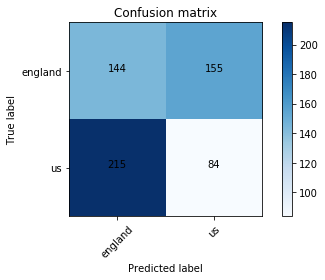

In [290]:
plot_confusion_matrix(cnf_mat, classes=accent_dict.values())

In [291]:
from sklearn import metrics
print(metrics.classification_report(y_true_labels, y_pred_labels))

             precision    recall  f1-score   support

    england       0.40      0.48      0.44       299
         us       0.35      0.28      0.31       299

avg / total       0.38      0.38      0.37       598



## Test at utterance level

In [219]:
def collate_fn(batch_tot):
    """This function takes list of samples and assembles a batch. It is intended to used in PyTorch DataLoader."""
    res, targets = zip(*batch_tot)
    lens = [len(r) for r in res]

    concats = []
    for mat in res:
        num_frames = mat.shape[0]
        frame_len = mat.shape[1]

        pre = np.stack([mat[0]] * NUM_CONCAT)
        post = np.stack([mat[-1]] * NUM_CONCAT)

        mat = np.concatenate([pre, mat, post])

        mat_tensor = torch.tensor(mat)
        mat_tensor = mat_tensor.view(-1)

        for i in range(NUM_CONCAT, num_frames + NUM_CONCAT):
            concat = mat_tensor[(i - NUM_CONCAT) * frame_len:(1 + i + NUM_CONCAT) * frame_len]

            concats.append(concat)
            #targets.append(accent_dict[id_])
            
    res = torch.stack(concats)
    
    tar = []

    [tar.extend([t] * lens[i]) for i, t in enumerate(targets)]
    tar = torch.tensor(tar)
    
    # shuffling in batch
#     idx = torch.randperm(tar.nelement())
#     res = res[idx]
#     tar = tar[idx]
    
    return res, tar, lens

class UtteranceConcatDataLoader(DataLoader):
    def __init__(self, *args, **kwargs):
        """
        Creates a data loader for SpeechDatasets.
        """
        super(UtteranceConcatDataLoader, self).__init__(*args, **kwargs)
        self.collate_fn = collate_fn

In [220]:
ut_test_dict, ut_dict = make_accent_dict('../data/CommonVoice_dataset/splits/for_notebooks/us-en_test.csv')

ut_test_dataset = ConcatDataset('../data/CommonVoice_dataset/kaldi/test-norm', 
                              ids_list('../data/CommonVoice_dataset/splits/for_notebooks/us-en_test.csv'), 
                              test_dict)

ut_test_loader = UtteranceConcatDataLoader(test_dataset, 
                                shuffle=False, 
                                num_workers=param['num_worker'],
                                batch_size=param['batch_size'])

ut_dev_dict, __ = make_accent_dict('../data/CommonVoice_dataset/splits/for_notebooks/us-en_dev.csv')

ut_dev_dataset = ConcatDataset('../data/CommonVoice_dataset/kaldi/dev-norm', 
                              ids_list('../data/CommonVoice_dataset/splits/for_notebooks/us-en_dev.csv'), 
                              test_dict)

ut_dev_loader = UtteranceConcatDataLoader(test_dataset, 
                                shuffle=False, 
                                num_workers=param['num_worker'],
                                batch_size=param['batch_size'])

In [221]:
def cnf_for_loader(loader):
    y_true, y_pred = [], []
    with torch.no_grad():
        for data in tqdm(loader, total=len(loader)):
            inputs, target_accents, lens = data
            inputs = inputs.cuda()
            target_accents = target_accents.cuda()

            out = best_model(inputs, lens)
            out = np.argmax(out, axis=1)

            i = 0
            for l in lens:                
                y_true.append(target_accents[i])
                y_pred.append(round(sum(out[i:i+l-1]).item()/l))
                i += l

        y_true_labels = [ut_dict[int(i)] for i in y_true]
        y_pred_labels = [ut_dict[int(i)] for i in y_pred]

    return y_true_labels, y_pred_labels

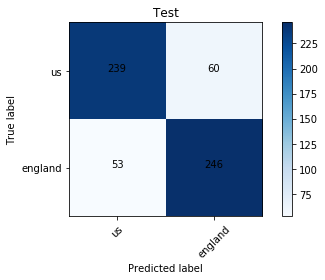

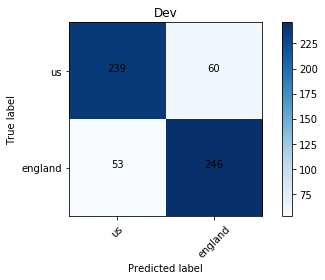

In [222]:
best_model.eval()
y_t_test, y_p_test = cnf_for_loader(ut_test_loader)
test_cnf_mat = confusion_matrix(y_t_test, y_p_test)
y_t_dev, y_p_dev = cnf_for_loader(ut_test_loader)
dev_cnf_mat = confusion_matrix(y_t_dev, y_p_dev)

plot_confusion_matrix(test_cnf_mat, title='Test', classes=accent_dict.values())
plot_confusion_matrix(dev_cnf_mat, title='Dev', classes=accent_dict.values())

In [223]:
print('Test', metrics.classification_report(y_t_test, y_p_test))
print('Dev', metrics.classification_report(y_t_dev, y_p_dev))

Test              precision    recall  f1-score   support

    england       0.82      0.80      0.81       299
         us       0.80      0.82      0.81       299

avg / total       0.81      0.81      0.81       598

Dev              precision    recall  f1-score   support

    england       0.82      0.80      0.81       299
         us       0.80      0.82      0.81       299

avg / total       0.81      0.81      0.81       598



## Data Loading old

In [6]:


def make_accent_dict(manifest_path):
    accent_dict = {}
    class_dict = {}
    with open(manifest_path) as f:
        for l in f:
            wav, txt, acc = l.split(',')
            num = extract_num(wav)
            accent = acc.strip()
            if accent not in class_dict:
                new_key = 0 if (len(class_dict) == 0) else max(class_dict.values()) + 1
                class_dict[accent] = new_key
            accent_dict[num] = class_dict[accent]
    return accent_dict, {v: k for k, v in class_dict.items()}

def concatenate_ark(ark, accent_dict):
    concats = []
    targets = []

    for key, mat in ark:
        id_  = extract_num(key)

        if id_ in accent_dict:
            num_frames = mat.shape[0]
            frame_len = mat.shape[1]

            pre = np.stack([mat[0]] * NUM_CONCAT) 
            post = np.stack([mat[-1]] * NUM_CONCAT)

            mat = np.concatenate([pre, mat, post])

            mat_tensor = torch.tensor(mat)
            mat_tensor = mat_tensor.view(-1)

            for i in range(NUM_CONCAT, num_frames + NUM_CONCAT):
                concat = mat_tensor[(i - NUM_CONCAT) * frame_len:(1 + i + NUM_CONCAT) * frame_len]

                concats.append(concat)
                targets.append(accent_dict[id_])

    return torch.stack(concats), torch.tensor(targets)

def concatenated_dataset(kaldi_path, manifest_path):
    train_kaldi = kaldi_io.read_mat_ark(kaldi_path)
    accent_dict, class_dict = make_accent_dict(manifest_path)
    concats, targets = concatenate_ark(train_kaldi, accent_dict)
    return concats, targets, class_dict

In [7]:
class KaldiDataset(torch.utils.data.Dataset):
    def __init__(self, X, Y):
        assert len(X) == len(Y)
        self._input_size = X.size(1) 
        self.X, self.Y = X, Y
    def __getitem__(self, index):
        return self.X[index], self.Y[index]
    def __len__(self):
        return len(self.X)

In [8]:
X_tr, Y_tr, class_dict = concatenated_dataset(param['train_kaldi'], param['train_manifest'])

if param['cuda']:
    X_tr = X_tr.cuda(); Y_tr = Y_tr.cuda()

train_dataset = KaldiDataset(X_tr, Y_tr)
train_loader = DataLoader(train_dataset, 
                          shuffle=True, 
                          num_workers=0, 
                          batch_size=param['batch_size'])

In [9]:
X_te, Y_te, __ = concatenated_dataset(param['test_kaldi'], param['test_manifest'])

if param['cuda']:
    X_te = X_te.cuda(); Y_ter = Y_te.cuda()

test_dataset = KaldiDataset(X_te, Y_te)
test_loader = DataLoader(test_dataset, 
                          shuffle=True, 
                          num_workers=0, 
                          batch_size=param['batch_size'])